In [1]:
import pandas as pd
import re
from selenium import webdriver
import time
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'black'
import os
import math

import warnings
warnings.filterwarnings('ignore')

# Parameters

In [2]:
game_id = "6593805"

# chess.com log in email and password are saved in a text file
f = open("creds.txt", "r")
credentials = f.read()
chess_account_id = credentials.split(",")[0]
chess_account_password = credentials.split(",")[1]

# Selenium Web Scraping
### Navigate to the game

In [34]:
game_url = "https://www.chess.com/4-player-chess?g={}".format(game_id)

# open game in python-controlled session
DRIVER_PATH = 'chromedriver'
driver = webdriver.Chrome(executable_path=DRIVER_PATH)

# start at log in page, where website prompts for account info
driver.get("https://www.chess.com/login_and_go")

# send username/email and password to appropriate locations and 'click' login button
driver.find_element_by_name('_username').send_keys(chess_account_id)
driver.find_element_by_name('_password').send_keys(chess_account_password)
driver.find_element_by_name('login').click()

# navigate to game of choice
driver.get(game_url)

# have python take a breather, incase the page is still loading
# otherwise, we immediately start looking for data added by Javascript that hasn't run yet 
time.sleep(3)

## Game Moves

In [4]:
# now we're ready to access and scrape all the game info

# list player color in order of play
colors = ["red", "blue", "yellow", "green"]

# find the table rows, part of the movesList table, which list moves
# each row = one round
allRounds = driver.find_elements_by_class_name('tableRow')

# lists to hold data
roundNumberList = []
playerList = []
moveList = []

# for each round, find the row number and the four moves. Save to lists. 
for round_num in allRounds:
    roundNumber = round_num.find_element_by_class_name("fullmoveNr").text
    moves = round_num.find_elements_by_class_name("move")
    
    for i in range(0,len(moves)):
        roundNumberList.append(roundNumber)
        playerList.append(colors[i])
        moveList.append(moves[i].text)
        
moves_data = pd.DataFrame({'round':roundNumberList, 'player':playerList, 'move':moveList})

print(len(moves_data))

312


In [5]:
moves_data.head(4)

,round,player,move
0,1.,red,Nf3
1,1.,blue,d4
2,1.,yellow,h11
3,1.,green,l10


## Points

In [35]:
# create lists to hold points for each player
redPoints = []
bluePoints = []
yellowPoints = []
greenPoints = []

# select all of the moves from the table
moves = driver.find_elements_by_class_name("move")

for move in moves:
    
    # short pause between each loop makes sure website is fully updated before python script scrapes it
    time.sleep(0.25)
    
    # click on each one; the board will show you what was happening at that move
    move.click()

    # find all elements which display player points
    playerPoints = driver.find_elements_by_class_name('player-points')
    
    # for each move, add current points of each player to lists
    redPoints.append(playerPoints[0].text)
    bluePoints.append(playerPoints[1].text)
    yellowPoints.append(playerPoints[2].text)
    greenPoints.append(playerPoints[3].text)

# sometimes I have a problem where points delivered on the very last move isn't registered
# so, a safety net:

playerPoints = driver.find_elements_by_class_name('player-points')
redPoints[-1] = playerPoints[0].text
bluePoints[-1] = playerPoints[1].text
yellowPoints.[-1] = playerPoints[2].text
greenPoints[-1] = playerPoints[3].text

assert(len(redPoints)==len(bluePoints)==len(moves_data))

moves_data['redPoints'] = redPoints
moves_data['bluePoints'] = bluePoints
moves_data['yellowPoints'] = yellowPoints
moves_data['greenPoints'] = greenPoints

moves_data['redPoints'] = moves_data['redPoints'].astype(int)
moves_data['bluePoints'] = moves_data['bluePoints'].astype(int)
moves_data['yellowPoints'] = moves_data['yellowPoints'].astype(int)
moves_data['greenPoints'] = moves_data['greenPoints'].astype(int)

### Points Viz

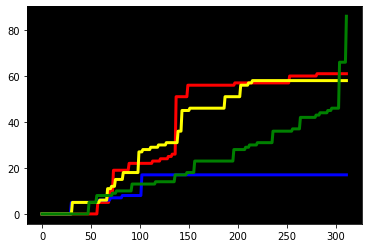

In [45]:
plt.plot(moves_data.index, moves_data['redPoints'], color='red', linewidth=3)
plt.plot(moves_data.index, moves_data['bluePoints'], color='blue', linewidth=3)
plt.plot(moves_data.index, moves_data['yellowPoints'], color='yellow', linewidth=3)
plt.plot(moves_data.index, moves_data['greenPoints'], color='green', linewidth=3)

# Derive position/coordinate origin and destination data

In [8]:
# this line shouldn't be necessary as I've already run it above, but I've run into errors when not re-running it. Investigate further
moves = driver.find_elements_by_class_name("move")

In [9]:
# Scrape the website for the advanced move notation
moveNotes = []

for move in moves:
    try:
        move_details = move.find_element_by_tag_name("div")
        moveNotes.append(move_details.get_attribute("title"))
    except:
        # got to a point where player has either resigned or been checkmated, skip them
        moveNotes.append("")
        
# add advanced move notation to dataframe
moves_data['moveNotes'] = moveNotes

In [10]:
# remove timestamp from new column
moves_data[['moveNote','time']] = moves_data["moveNotes"].str.split(" • ",expand=True)
del moves_data["time"]
del moves_data['moveNotes'] # we don't really need this for anything now

# split the expanded notation on either a hyphen or an x: 
# both represent origin - destination for a piece. x just means capture.
moves_data[['origin','destination']] = moves_data["moveNote"].str.split('[-x]', 1, expand=True)

In [11]:
# castling is notated as 'O-O' or 'O-O-O', therefore needs overwritten: 
for num in moves_data.index:
    # king side castle
    if moves_data['moveNote'][num] == "O-O":
        #  if red, origin is h1 and destination is j1
        if moves_data['player'][num] == "red":
            moves_data['origin'][num] = "h1"
            moves_data['destination'][num] = "j1"
        # if blue, origin is a8, and destination is a10
        elif moves_data['player'][num] == "blue":
            moves_data['origin'][num] = "a8"
            moves_data['destination'][num] = "a10"
        # if yellow, origin is g14 and destination is e14
        elif moves_data['player'][num] == "yellow":
            moves_data['origin'][num] = "g14"
            moves_data['destination'][num] = "e14"
        # if green, origin is n7 and destination is n5
        elif moves_data['player'][num] == "green":
            moves_data['origin'][num] = "n7"
            moves_data['destination'][num] = "n5"
    # queen side castle
    elif moves_data['moveNote'][num] == "O-O-O":
        #  if red, origin is h1 and destination is f1
        if moves_data['player'][num] == "red":
            moves_data['origin'][num] = "h1"
            moves_data['destination'][num] = "f1"
        # if blue, origin is a8, and destination is a6
        elif moves_data['player'][num] == "blue":
            moves_data['origin'][num] = "a8"
            moves_data['destination'][num] = "a6"
        # if yellow, origin is g14 and destination is i14
        elif moves_data['player'][num] == "yellow":
            moves_data['origin'][num] = "g14"
            moves_data['destination'][num] = "i14"
        # if green, origin is n7 and destination is n9
        elif moves_data['player'][num] == "green":
            moves_data['origin'][num] = "n7"
            moves_data['destination'][num] = "n9"

### Remove extraneous, non-location info from origin and destination columns

In [12]:
def removeExtraInfo(original_string):

    try:
        # queen promotion, check, checkmate, Knight, Brook, Rook, King, Queen
        characters_to_remove = "=D+#NBRKQ"
        pattern = "[" + characters_to_remove + "]"
        return re.sub(pattern, "", original_string)
    except:
        return ""

In [13]:
moves_data['origin'] = moves_data['origin'].apply(removeExtraInfo)
moves_data['destination'] = moves_data['destination'].apply(removeExtraInfo)

In [14]:
# create folder where all data files from this game will live
os.makedirs("dashboard/data/{}".format(game_id))

destinations = pd.DataFrame(moves_data['destination'].value_counts()).reset_index()
destinations.columns = ['coordinate','value']
destinations = destinations[destinations['coordinate']!=""]

# the value counts of each square that served as a destination will be used in the heatmap
destinations.to_csv("dashboard/data/{}/destinations.csv".format(game_id), index=False)

# Use move notation to derive extra info
### For each move, we will collect data on: which piece was moved, if the move resulted in capturing a piece from another player, if a pawn was promoted, if a check or checkmate was delivered

In [15]:
def getPiece(move):
    
    # K = King
    # Q = Queen
    # R = Rook (but just "R" means resign)
    # B = Bishop
    # N = Knight
    # _ = pawn
    
    # if this is true, move is missing. So return a blank.
    if move != move:
        return ""
    
    if 'O' in move: # they castled
        return 'King' # we'll credit the king, even though the rook is involved too
    if 'K' in move: # king
        return 'King'
    elif 'Q' in move: # queen
        return 'Queen'
    elif 'B' in move: # bishop
        return 'Bishop'
    elif move == 'R': # this means they just resigned...
        return "" # ...which does not require moving a piece
    elif ('R' in move):
        return 'Rook' # rook
    elif 'N' in move:
        return 'Knight' # knight
    else: # the 'P' for pawn isn't included in notation for pawn move (ugh)
        return 'Pawn'
    
def lookForCapture(move):
    
    # if this is true, move is missing. So return a blank.
    if move != move:
        return ""
    elif 'x' in move: # 'x' represents a capture
        return 1
    else:
        return 0

In [16]:
# column: which piece was moved?
moves_data['piece'] = moves_data['move'].apply(getPiece)

# column: did this move capture an enemy piece? 1 = yes, 0 = no
moves_data['capture'] = moves_data['moveNote'].apply(lookForCapture)
        
# Note: if the data is ever needed, here is also where columns such as 'pawnPromoted' and 'check/checkmated' can be added
# pawn promoted = "=D" in moveNotes
# check = +
# checkmated = #

## For moves which deliver a checkmate, compute *who* got checkmated
### The chess notation makes it obvious which moves deliver a checkmate - "#" = checkmate. However, nothing in the chess notation tells us *who* was checkmated. So computing this vital piece of info will require some extra steps. 

In [17]:
# step 1: web scrape chatbox for game info messages (this excludes player chat)
chatbox_info_messages = driver.find_elements_by_class_name("infomsg")

# extract only the "___ checkmated!" messages
checkmate_messages = []
for message in chatbox_info_messages:
    if "checkmated" in message.text:
        checkmate_messages.append(message.text)
        
print(checkmate_messages)

# validate the number of checkmate messages = the number of checkmate game notations
assert(len(checkmate_messages) == len(moves_data[moves_data['moveNote'].str.contains('#')]))

# because the checkmate messages list the player's usernames, as opposed to colors, we need to create a dictionary
playerNames = driver.find_elements_by_class_name('truncate120') # list of player names
playerDict = {}

# create the player name : player color dictionary
for num in range(0,len(playerNames)):
    playerDict[playerNames[num].text] = colors[num]
    
print(playerDict)

# new column: name of checkmated player *if* there was a checkmate on any given move
moves_data['checkmate_target'] = ''

numCheckmates = 0 # a variable to keep track of how many checkmates the game has had so far
for i in moves_data.index:
     # if we come across a move where a checkmate was delivered
    if "#" in moves_data['moveNote'][i]:
        # match up checkmate number with checkmate messages, which are ordered chronologically
        checkmate_message = checkmate_messages[numCheckmates]
        numCheckmates = numCheckmates + 1 # increment this value
        
        # use regex to extract name from checkmate message
        checkmate_name = re.search("(.{,}) checkmated!", checkmate_message).group(1)
        
        # who was checkmated?
        print(checkmate_name)
        
        # and what was their color?
        print(playerDict[checkmate_name])
        
        # fill in 'checkmate_target' column
        moves_data['checkmate_target'][i] = playerDict[checkmate_name]

['byrookorbycrook7 checkmated!', 'leroi7 checkmated!', '3Angels checkmated!']
{'leroi7': 'red', 'byrookorbycrook7': 'blue', '3Angels': 'yellow', 'AZTECA_CHESS': 'green'}
byrookorbycrook7
blue
leroi7
red
3Angels
yellow


### Who checkmated whom and when?

In [18]:
moves_data[moves_data['checkmate_target']!=""][['round', 'player', 'move', 'checkmate_target']]

,round,player,move,checkmate_target
136,35.,red,Qxe11+#,blue
303,76.,green,Qk8+#,red
311,78.,green,Qm10+#,yellow


# Random analysis and stats

In [19]:
red = moves_data[moves_data['player']=='red']
blue = moves_data[moves_data['player']=='blue']
yellow = moves_data[moves_data['player']=='yellow']
green = moves_data[moves_data['player']=='green']

In [20]:
moves_data['piece'].value_counts()

Pawn      111
Queen      59
King       53
Rook       39
Knight     27
Bishop     23
Name: piece, dtype: int64

In [21]:
# out of all the moves made, what percent were captures?
print(len(moves_data[moves_data['capture'] == 1]) / (len(moves_data[moves_data['capture'] == 0]) + len(moves_data[moves_data['capture'] == 1])))

0.16987179487179488


In [22]:
# by player?
print(len(red[red['capture'] == 1]) / (len(red[red['capture'] == 0]) + len(red[red['capture'] == 1])))
print(len(blue[blue['capture'] == 1]) / (len(blue[blue['capture'] == 0]) + len(blue[blue['capture'] == 1])))
print(len(yellow[yellow['capture'] == 1]) / (len(yellow[yellow['capture'] == 0]) + len(yellow[yellow['capture'] == 1])))
print(len(green[green['capture'] == 1]) / (len(green[green['capture'] == 0]) + len(green[green['capture'] == 1])))

0.16666666666666666
0.0641025641025641
0.24358974358974358
0.20512820512820512


# Running Measure Of Material Strength And How Many Pieces Each Player Still Has At Each Turn
### Material Strength measured by: queens = +9, bishops / rooks = +5, knights +3, pawns = +1

## First: I need a master list of all pieces and their starting coordinates

In [23]:
pieces = ["pawn","pawn","pawn","pawn","pawn","pawn","pawn","pawn","rook","knight","bishop","queen","king","bishop","knight","rook"]

color = ["red","red","red","red","red","red","red","red","red","red","red","red","red","red","red","red"]
squares = ["d2","e2","f2","g2","h2","i2","j2","k2","d1","e1","f1","g1","h1","i1","j1","k1"]
red_positions = pd.DataFrame({"player":color, "piece":pieces, "coordinate":squares})

color = ["blue","blue","blue","blue","blue","blue","blue","blue","blue","blue","blue","blue","blue","blue","blue","blue"]
squares = ["b11","b10","b9","b8","b7","b6","b5","b4","a11","a10","a9","a7","a8","a6","a5","a4"]
blue_positions = pd.DataFrame({"player":color, "piece":pieces, "coordinate":squares})

color = ["yellow","yellow","yellow","yellow","yellow","yellow","yellow","yellow","yellow","yellow","yellow","yellow","yellow","yellow","yellow","yellow"]
squares = ["k13","j13","i13","h13","g13","f13","e13","d13","k14","j14","i14","h14","g14","f14","e14","d14"]
yellow_positions = pd.DataFrame({"player":color, "piece":pieces, "coordinate":squares})

color = ["green","green","green","green","green","green","green","green","green","green","green","green","green","green","green","green"]
squares = ["m4","m5","m6","m7","m8","m9","m10","m11","n4","n5","n6","n8","n7","n9","n10","n11"]
green_positions = pd.DataFrame({"player":color, "piece":pieces, "coordinate":squares})

piece_positions = pd.concat([red_positions,blue_positions,yellow_positions,green_positions])
piece_positions = piece_positions.reset_index()
del piece_positions['index']

# we'll need this later for the javascript replica...
piece_positions.to_csv("pieces.csv", index=False)

## Second, I need a function to decrease material strength value and call it when appropriate
### Note: material strength can also increase if a player promotes a pawn to a queen. We'll handle that in part #3.

In [24]:
def decreaseMaterialStrength(pieceName, currentMaterialStrength):
    """
    Each player starts with 16 pieces, but typically gradually lose these pieces over the course of the game.
    We refer to a player's pieces as their 'material'. Their 'material strength' is the sum of their pieces values.
    Not all pieces are created equally. A queen is worth 9 material strength points, a pawn is worth 1. 
    This function is called below when a piece is captured. It's parameters are the name of the peice being captured,
    and the victim's current material strength (int)
    This function returns their new material strength (int)
    """

    if pieceName == 'pawn':
        return currentMaterialStrength - 1
    elif pieceName == 'knight':
        return currentMaterialStrength - 3
    elif pieceName == 'bishop':
        return currentMaterialStrength - 5
    elif pieceName == 'rook':
        return currentMaterialStrength - 5
    elif pieceName == 'queen':
        return currentMaterialStrength - 9
    elif pieceName == 'queen_':
        return currentMaterialStrength - 9
    else:
        print(pieceName)
        return currentMaterialStrength

## Third, loop over every move in moves_data. Every time a piece gets moved, update its position in the positions dataframe. 
### Pay special attention to collisions; aka when a piece moves to a square already occupied by a piece. This is a capture! So both pieces need to be updated: the one moving, and the one being captured.
### When this happens, update the attacked player's material strength. After making all changes and calculations, record each player's current material strength for each stage (move) of the game.
### Also consider special cases: pawns being promoted to queens increases material strength, for example.

In [25]:
piece_positions = pd.concat([red_positions,blue_positions,yellow_positions,green_positions])
piece_positions = piece_positions.reset_index()
del piece_positions['index']

# material strength values - this is how strong the sum of a player's pieces are
redMaterial = 43 # this represents: 1 queen, 2 bishops, 2 rooks, 2 knights, 8 pawns
blueMaterial = 43
yellowMaterial = 43
greenMaterial = 43

redMaterialList = []
blueMaterialList = []
yellowMaterialList = []
greenMaterialList = []

# keep track of how many pieces each player has left
redPieces = 16
bluePieces = 16
yellowPieces = 16
greenPieces = 16

redPiecesList = []
bluePiecesList = []
yellowPiecesList = []
greenPiecesList = []

for move in moves_data.index:
    
    # NaN check
    if moves_data["move"][move] == "":
        # if true, then the player didn't move (they've been checkmated, resigned, etc)
        # so do nothing on this loop
        redMaterialList.append(redMaterial)
        blueMaterialList.append(blueMaterial)
        yellowMaterialList.append(yellowMaterial)
        greenMaterialList.append(greenMaterial)
        redPiecesList.append(redPieces)
        bluePiecesList.append(bluePieces)
        yellowPiecesList.append(yellowPieces)
        greenPiecesList.append(greenPieces)
        continue  
    # resigning, timing out, or getting stalemated is a move which requires no pieces
    elif (moves_data["move"][move] == "R") or (moves_data["move"][move] == "C") or (moves_data["move"][move] == "T") or (moves_data["move"][move] == "S"):
        redMaterialList.append(redMaterial)
        blueMaterialList.append(blueMaterial)
        yellowMaterialList.append(yellowMaterial)
        greenMaterialList.append(greenMaterial)
        redPiecesList.append(redPieces)
        bluePiecesList.append(bluePieces)
        yellowPiecesList.append(yellowPieces)
        greenPiecesList.append(greenPieces)
        continue
    
    # for whatever piece was moved, what was the origin?
    origin = moves_data["origin"][move]
    
    # and where did the piece move to?
    newSquare = moves_data["destination"][move]
    
    # is anyone else already on the square the piece is moving to? If so, this is a capture
    piece_at_newSquare = piece_positions.query("coordinate=='{}'".format(newSquare))
    if len(piece_at_newSquare) == 1: # this should always be 0 or 1 (can't have more than 1 piece on the same square)
        piece_positions['coordinate'][piece_at_newSquare.index[0]] = 'captured'
        
        # get color of captured piece
        playerAttacked = piece_positions['player'][piece_at_newSquare.index[0]]
        # call decrease material strength function on appropriate player
        if playerAttacked == 'red':
            redMaterial = decreaseMaterialStrength(piece_positions['piece'][piece_at_newSquare.index[0]], redMaterial)
            redPieces = redPieces - 1
        elif playerAttacked == 'blue':
            blueMaterial = decreaseMaterialStrength(piece_positions['piece'][piece_at_newSquare.index[0]], blueMaterial)
            bluePieces = bluePieces - 1
        elif playerAttacked == 'yellow':
            yellowMaterial = decreaseMaterialStrength(piece_positions['piece'][piece_at_newSquare.index[0]], yellowMaterial)
            yellowPieces = yellowPieces - 1
        elif playerAttacked == 'green':
            greenMaterial = decreaseMaterialStrength(piece_positions['piece'][piece_at_newSquare.index[0]], greenMaterial)
            greenPieces = greenPieces - 1

    # find index value of row representing the moved piece; replace coordinate column value with newSquare
    index = piece_positions.query("coordinate=='{}'".format(origin)).index[0]
    piece_positions['coordinate'][index] = newSquare
    
    # if a player pushed a pawn to promotion, we need to update that pawns piece name to queen
    if "=D" in moves_data['moveNote'][move]:
        piece_positions['piece'][index] = 'queen_'
        
        # and update the players material strength - they just got an upgrade
        if moves_data['player'][move] == 'red':
            redMaterial = redMaterial + 8 # from pawns value of 1 to queens value of 9
        elif moves_data['player'][move] == 'blue':
            blueMaterial = blueMaterial + 8
        elif moves_data['player'][move] == 'yellow':
            yellowMaterial = yellowMaterial + 8
        elif moves_data['player'][move] == 'green':
            greenMaterial = greenMaterial + 8
    
    # a castle moves both the king and the rook to new pieces
    # we covered the king. Now for updating the rook's position...
    if moves_data["move"][move] == "O-O":
        if moves_data['player'][move] == "red":
            origin = "k1" # where the rook starts
            newSquare = "i1" # where the rook lands after the castle
        elif moves_data['player'][move] == "blue":
            origin = "a11" 
            newSquare = "a9"
        elif moves_data['player'][move] == "yellow":
            origin = "d14" 
            newSquare = "f14"
        elif moves_data['player'][move] == "green":
            origin = "n4" 
            newSquare = "n6"
        index = piece_positions.query("coordinate=='{}'".format(origin)).index[0] # find and update the rook's position
        piece_positions['coordinate'][index] = newSquare
    # queen side castle
    elif moves_data["move"][move] == "O-O-O":
        if moves_data['player'][move] == "red":
            origin = "d1" # where the rook starts
            newSquare = "g1" # where the rook lands after the castle
        elif moves_data['player'][move] == "blue":
            origin = "a4" 
            newSquare = "a7"
        elif moves_data['player'][move] == "yellow":
            origin = "k14" 
            newSquare = "h14"
        elif moves_data['player'][move] == "green":
            origin = "n11" 
            newSquare = "n8"
        index = piece_positions.query("coordinate=='{}'".format(origin)).index[0] # find and update the rook's position
        piece_positions['coordinate'][index] = newSquare
        
    # save each player's current material strength at this game stage
    redMaterialList.append(redMaterial)
    blueMaterialList.append(blueMaterial)
    yellowMaterialList.append(yellowMaterial)
    greenMaterialList.append(greenMaterial)
    
    # save each player's number of pieces currently
    redPiecesList.append(redPieces)
    bluePiecesList.append(bluePieces)
    yellowPiecesList.append(yellowPieces)
    greenPiecesList.append(greenPieces)
    
    # possible future data quality check: assert that the piece we think moved matches the 'piece column' in moves_data df
    #something using piece_positions.query("coordinate=='{}'".format(origin))['piece'].iloc[0]
    # if we want, we could also assert piece captures with the capture column in moves_data df
    
assert(len(redMaterialList) == len(moves_data))
assert(len(redPiecesList) == len(moves_data))

### Attach material values and number of pieces to main df

In [26]:
moves_data['redMaterial'] = redMaterialList
moves_data['blueMaterial'] = blueMaterialList
moves_data['yellowMaterial'] = yellowMaterialList
moves_data['greenMaterial'] = greenMaterialList

moves_data['redNumPieces'] = redPiecesList
moves_data['blueNumPieces'] = bluePiecesList
moves_data['yellowNumPieces'] = yellowPiecesList
moves_data['greenNumPieces'] = greenPiecesList

In [27]:
# bug in my code: if a player is checkmated and in future rounds their void pieces are captured, that shouldn't
# affect said player's material strength score. Instead, once a player is checkmated, resigns, or times out,
# we want to freeze their material strength score for the rest of the game

redout = 0
blueout = 0
yellowout = 0
greenout = 0

# use loop to find point at which each player stops playing, and overwrite all future material strength scores 
for num in moves_data.index:
    # it's a "non-move"
    if moves_data['move'][num] == "":
        # if it's a player's *first* non-move, save their material value
        if (moves_data['player'][num] == "red") & (redout == 0):
            redout = 1
            redMaterial = moves_data['redMaterial'][num]
            redPieces = moves_data['redNumPieces'][num]
        if (moves_data['player'][num] == "blue") & (blueout == 0):
            blueout = 1
            blueMaterial = moves_data['blueMaterial'][num]
            bluePieces = moves_data['blueNumPieces'][num]
        if (moves_data['player'][num] == "yellow") & (yellowout == 0):
            yellowout = 1
            yellowMaterial = moves_data['yellowMaterial'][num]
            yellowPieces = moves_data['yellowNumPieces'][num]
        if (moves_data['player'][num] == "green") & (greenout == 0):
            greenout = 1
            greenMaterial = moves_data['greenMaterial'][num]
            greenPieces = moves_data['greenNumPieces'][num]
            
    if redout == 1:
        # overwrite their material strength as value when they stopped playing
        moves_data['redMaterial'][num] = redMaterial
        moves_data['redNumPieces'][num] = redPieces
    if blueout == 1:
        moves_data['blueMaterial'][num] = blueMaterial
        moves_data['blueNumPieces'][num] = bluePieces
    if yellowout == 1:
        moves_data['yellowMaterial'][num] = yellowMaterial
        moves_data['yellowNumPieces'][num] = yellowPieces
    if greenout == 1:
        moves_data['greenMaterial'][num] = greenMaterial
        moves_data['greenNumPieces'][num] = greenPieces
        
# note: if red checkmates green, blue and yellow both go before green is registered as "non-moving"
# that's two moves in which green's void pieces could be captured. My for loop doesn't account for that.

### Material Strength Over Time Viz

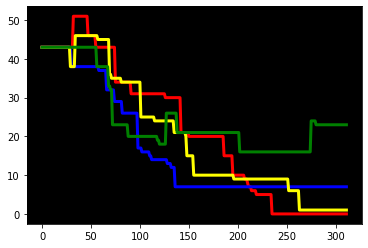

In [28]:
plt.plot(moves_data.index, moves_data['redMaterial'], color='red', linewidth=3)
plt.plot(moves_data.index, moves_data['blueMaterial'], color='blue', linewidth=3)
plt.plot(moves_data.index, moves_data['yellowMaterial'], color='yellow', linewidth=3)
plt.plot(moves_data.index, moves_data['greenMaterial'], color='green', linewidth=3)

### Material Strength Lost Vs Points Earned
#### Read this graph right to left

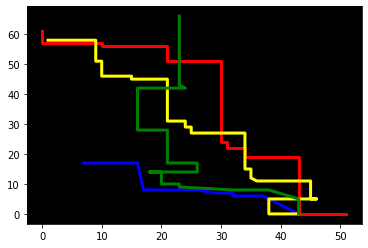

In [29]:
plt.plot(moves_data['redMaterial'], moves_data['redPoints'], color='red', linewidth=3)
plt.plot(moves_data['blueMaterial'], moves_data['bluePoints'], color='blue', linewidth=3)
plt.plot(moves_data['yellowMaterial'],moves_data['yellowPoints'],  color='yellow', linewidth=3)
plt.plot(moves_data['greenMaterial'], moves_data['greenPoints'], color='green', linewidth=3)

## View the final position of each of blue's pieces
#### Note: "queen_" is a former pawn

In [30]:
piece_positions[piece_positions['player']=='blue']

,player,piece,coordinate
16,blue,pawn,captured
17,blue,pawn,captured
18,blue,pawn,captured
19,blue,pawn,captured
20,blue,pawn,captured
21,blue,pawn,captured
22,blue,pawn,captured
23,blue,pawn,d4
24,blue,rook,captured
25,blue,knight,captured


# Save data

In [46]:
def stripPeriod(value):
    return value.strip(".")

# might be helpful to have round numbers listed without ".0"
moves_data["round"] = moves_data["round"].apply(stripPeriod)

# save data file
moves_data.to_csv("dashboard/data/{}/moves.csv".format(game_id), index=False)

In [32]:
#import pandas as pd 
#moves_data = pd.read_csv("dashboard/data/{}/moves.csv".format(game_id))
#moves_data = moves_data.fillna("")